In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint as ci
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib.animation import FuncAnimation

In [2]:
def get_clean_cape_dataframe(filepath):
    """
    read the cleaned data as dataframe
    Args:
        filepath: str
        the location of the csv file
    Returns:
        dataframe
    """
    assert isinstance(filepath, str), 'The type of filepath must be string'
    df = pd.read_csv(filepath)
    return df

In [3]:
def get_depts_and_courses_dictionary(df):
    """
    get all courses for departments
    Args:
        df: dataframe

    Returns:
        depths_courses: dict

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_depts_and_courses_dictionary(df)
        depths_courses = {'AAS': ['10', '11', '170', '190'], 'ANAR': ['100', '114', '115', '116', '135', '135S', '143']}

    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    df = (df['Course_ID'].str.split(expand=True)
          .rename(columns={0: 'dept', 1: 'course'})
          .drop_duplicates())

    depts = natsorted(df.dept.unique())
    df = df.set_index(['dept', 'course']).sort_index()

    depts_courses = {dept: natsorted(df.loc[dept].index) for dept in depts}

    return depts_courses

In [4]:
def get_global_avg_time(df):
    """
    return the average time and stand deviation for all courses
    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    gb = df[['Course_ID', 'time']]
    global_average = float(gb.mean())
    global_sd = float(gb.std())
    
    return global_average, global_sd
    
def get_time_df(df, global_average, global_sd):
    """
    group the dataframe using the Course_ID, the average spending time for a particular course between different terms is calculated
    compare the time with other courses
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_time_df(df)
           
        new_df:
            Course_ID  time  depart_avg_time  global_avg_time  depart_time_diff  global_time_diff              
        0       AAS 10  4.07             3.75         5.494174              0.32         -1.424174
        1      AAS 170  3.61             3.75         5.494174             -0.14         -1.884174  
        2      AAS 190  2.93             3.75         5.494174             -0.82         -2.564174  
        3     ANAR 100  3.17             4.10         5.494174             -0.93         -2.324174  
        4     ANAR 116  3.59             4.10         5.494174             -0.51         -1.904174  
    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    df = df[['Course_ID', 'time']]
    # groupby to get average time for same courses in different quarters
    gb = df[['time', 'Course_ID']].groupby('Course_ID').mean().round(2)
    # print(gb)

    # for departments
    depths_time = {}
    depths_courses = get_depts_and_courses_dictionary(df)
    for dept, courses in depths_courses.items():
        times = []
        for course in courses:
            mask = df['Course_ID'].str.startswith(dept + ' ' + course)
            if mask.any():
                times.extend(df.loc[mask, 'time'])

        if times:
            average_time = np.mean(times)
            std_deviation = np.std(times)
            depths_time[dept] = (average_time, std_deviation)

    # for all courses
#     global_average = float(gb.mean())
#     global_sd = float(gb.std())

    df['department'] = df['Course_ID'].str.split().str[0]
    df['depart_avg_time'] = df['department'].map(lambda x: depths_time[x][0] if x in depths_time else None)

    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['global_avg_time'] = global_average
    gb['depart_time_diff'] = gb['time'] - gb['depart_avg_time']
    gb['global_time_diff'] = gb['time'] - global_average

    return gb

In [5]:
def get_global_avg_grade(df):
    """
    return the average grade and stand deviation for all courses
    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    gb = df[['Course_ID', 'actual_gpa']]
    global_average = float(gb.mean())
    global_sd = float(gb.std())
    return global_average, global_sd
    
    
def get_grade_dev_df(df,global_average,global_sd):
    """
    group the dataframe using the Course_ID, the average expected and actual gpa for a particular course between different terms is calculated
    compare the expected gpa and actual gpa
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_grade_dev_df(df)

        new_df:
                Course_ID  expected_gpa  actual_gpa   dev
            0       AAS 10          3.79        3.56 -0.23
            1      AAS 170          3.89        3.68 -0.21
            2      AAS 190          3.86        4.00  0.14
            3     ANAR 100          3.33        3.30 -0.03
            4     ANAR 116          3.70        3.35 -0.35
            ...        ...           ...         ...   ...
            1205   VIS 70N          3.78        3.60 -0.18
            1206    VIS 80          3.84        3.82 -0.02
            1207  WCWP 100          3.54        3.49 -0.05
            1208  WCWP 10A          3.73        3.65 -0.08
            1209  WCWP 10B          3.55        3.50 -0.05
                            
    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    df = df[['Course_ID', 'expected_gpa', 'actual_gpa']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['dev'] = gb['actual_gpa'] - gb['expected_gpa']
    
    gb['global_avg_grade'] = global_average
    return gb


In [6]:
def get_class_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average class recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_class_rmd_df(df)

        new_df:
             Course_ID  rmd_class
        0       AAS 10      85.68
        1       AAS 11      93.50
        2      AAS 170      94.45
        3      AAS 190     100.00
        4     ANAR 100     100.00
        ...        ...        ...
        2447    VIS 84      80.55
        2448     VIS 9      80.60
        2449  WCWP 100      92.66
        2450  WCWP 10A      91.66
        2451  WCWP 10B      90.33
    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    df = df[['Course_ID', 'rmd_class']]
    # groupby to get the mean course recommendation ratio and round to 2 decimal places
    gb = df.groupby(['Course_ID']).mean().round(2).reset_index()
    
    return gb

In [7]:
def get_instr_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average instructor recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_instr_rmd_df(df):

        new_df:
                Course_ID                        instr  rmd_instr
        0       AAS 10    Butler, Elizabeth Annette      88.63
        1      AAS 170    Butler, Elizabeth Annette      88.90
        2      AAS 190  Puritty, Chandler Elizabeth     100.00
        3     ANAR 100                Fortier, Jana     100.00
        4     ANAR 116            Shtienberg, Gilad     100.00
        ...        ...                          ...        ...
        2256  WCWP 10A              Savage, Sarah S     100.00
        2257  WCWP 10A                Susi, Natalie      97.10
        2258  WCWP 10B            Gagnon, Jeffrey C      95.80
        2259  WCWP 10B           Tocki, Jasmine Rae     100.00
        2260  WCWP 10B         Welji, Haleema Nazir      93.30
    """
    assert isinstance(df, pd.DataFrame), 'Input type must be dataframe'
    df = df[['Course_ID', 'instr', 'rmd_instr']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby(['Course_ID','instr']).mean().round(2).reset_index()
    
    return gb

In [8]:
df = get_clean_cape_dataframe('data_clean.csv')

In [9]:
df

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",SP23,66,48,93.5,100.0,2.80,AAS 10,Intro/African-American Studies (A),A-,3.84,B+,3.67
1,"Butler, Elizabeth Annette",SP23,20,7,100.0,100.0,2.50,AAS 170,Legacies of Research (A),A-,3.86,A-,3.92
2,"Shtienberg, Gilad",SP23,26,6,100.0,83.3,3.83,ANAR 115,Coastal Geomorphology/Environ (A),B+,3.50,B,3.07
3,"Braswell, Geoffrey E.",SP23,22,9,100.0,100.0,5.17,ANAR 155,Stdy Abrd: Ancient Mesoamerica (A),A,4.00,A,4.00
4,"Hrvoj Mihic, Branka",SP23,22,4,100.0,100.0,2.50,ANBI 111,Human Evolution (A),A,4.00,B-,2.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15400,"Blomstedt, Elizabeth Ann",SP19,20,6,100.0,100.0,4.50,WCWP 100,Academic Writing (B),B+,3.60,B+,3.42
15401,"McCleary, Keith Long",SP19,20,19,84.2,94.4,8.39,WCWP 100,Academic Writing (C),B-,2.95,B,3.17
15402,"Young, Mark T",SP19,20,8,75.0,87.5,8.00,WCWP 100,Academic Writing (F),B,3.13,B+,3.34
15403,"Gagnon, Jeffrey C",SP19,150,126,76.9,91.5,5.21,WCWP 10A,The Writing Course A (0),B,3.11,B,3.21


In [10]:
ddd = get_depts_and_courses_dictionary(df)
print(len(ddd.keys()))

count = 0
for x in ddd:
    count += len(ddd[x])
print(count)


 

106
2452


## Input the weights

Please provide your preferences for each category on a scale of 1 to 10, separated by spaces

(GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

For example, enter: 10 10 5 5 5

In [11]:
user_input = input("Enter ratings separated by spaces: ")
assert len(user_input) != 0, 'Input should not be none'
user_input_splits = user_input.split()

for user_input_split in user_input_splits:
    assert len(user_input_splits) == 5, 'Invalid input weights, there should be 5 weights'
    try:
        int(user_input_split)
    except ValueError:
        'Input weights should be integer or float'

ratings = list(map(int, user_input_splits))

def weights(ratings):
    """
    Calculate weights based on rankings
    
    Args:
        ratings: input ratings
    
    Return:
        list: ration of ratings to sum of all ratings
    """
    assert isinstance(ratings, list), 'Input must be a list.'
    weights = []
    for i in ratings:
        weights.append(i/sum(ratings))
    return weights
        

Enter ratings separated by spaces: 10 10 10 5 5


In [12]:
weights = weights(ratings)
print(weights)

[0.25, 0.25, 0.25, 0.125, 0.125]


## Input the desired quarters

Please input a space seperated list of desired quarters using the corresponding numbers:

1. Fall
2. Winter
3. Spring
4. Summer Session 1
5. Summer Session 2

For example, entering `1 2 3` will select Fall, Winter, and Spring.

In [13]:
# Check if the quarter is valid
input_quarters = input("Enter quarter numbers separated by spaces: ").split()
assert len(input_quarters) != 0, 'Input should not be none'
for input_quarter in input_quarters:
    assert input_quarter.isnumeric(), 'Input is not numeric'
    assert int(input_quarter) < 6 and int(input_quarter) > 0, 'Quarters are out of range'
    
quarters = list(map(int, input_quarters))

print(quarters)

Enter quarter numbers separated by spaces: 2
[2]


## Input the desired depeartments

Please input a space seperated list of desired quarters 
Ex: ECE CSE

In [14]:
# create a dictionary of all departments and courses
all_depts_dict = get_depts_and_courses_dictionary(df)

user_input = input("Enter department names separated by spaces: ")
assert len(user_input) != 0, 'Input should not be none'
depts_input = user_input.split()
depts = []
for dept in depts_input:
    dept = dept.upper()
    assert dept in all_depts_dict, 'The input is not a valid department'
    depts.append(dept)

depts

Enter department names separated by spaces: ECE


['ECE']

In [15]:
# Map the quarter to the integer
maps = {1: 'FA', 2:'WI', 3:'SP', 4: 'S1', 5:'S2'}

# maps quarters to string name and slices df based on quarters
quarter_str = '|'.join([maps[q] for q in quarters])
df2 = df[df['term'].str.contains(quarter_str)].reset_index(drop=True)
df2

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Butler, Elizabeth Annette",WI23,65,46,93.5,93.3,4.15,AAS 11,Intro Black Diasporic Studies (A),A-,3.84,A-,3.71
1,"Shtienberg, Gilad",WI23,27,9,100.0,100.0,3.61,ANAR 116,Sea Level ChangeIsrael (A),A,4.00,B+,3.62
2,"Braswell, Geoffrey E.",WI23,24,15,100.0,92.9,3.42,ANAR 135,Ancient Mediterranean Civ (A),A,4.00,A-,3.99
3,"Rodriguez, Eric Andrew",WI23,41,23,100.0,100.0,4.07,ANAR 164,Underwater Archaeology (A),A-,3.80,B+,3.63
4,"Non, Amy L",WI23,71,45,84.4,81.8,4.28,ANBI 130,Biology of Inequality (A),B+,3.42,B+,3.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4236,"Cartwright, Lisa",WI20,280,91,82.8,89.7,3.20,VIS 84,History Of Film (A),A-,3.84,A-,3.80
4237,"McCleary, Keith Long",WI20,21,21,81.0,90.5,6.12,WCWP 100,Academic Writing (A),B+,3.43,B+,3.36
4238,"Twohig, Niall Ivan",WI20,20,4,100.0,100.0,9.83,WCWP 100,Academic Writing (I),B+,3.33,B+,3.69
4239,"Gagnon, Jeffrey C",WI20,324,183,72.7,88.5,4.40,WCWP 10A,The Writing Course A (0),B+,3.47,B+,3.32


In [16]:
# Slice the dataframe and only keep the desired department
df_quarter = df2[df2['Course_ID'].str.contains('|'.join(depts))].reset_index(drop=True)
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa
0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals (A),B,3.24,B-,2.75
1,"Le, Hanh-Phuc",WI23,70,54,94.3,96.2,8.31,ECE 102,Intro/Active Circuit Design (A),B,3.08,B,3.04
2,"Lo, Yu-Hwa",WI23,50,24,83.3,75.0,4.75,ECE 103,Fundamntls/Devices & Materials (A),B,3.08,B-,2.89
3,"Lomakin, Vitaliy",WI23,79,31,71.0,70.0,8.82,ECE 107,Electromagnetism (A),B-,2.87,B,3.06
4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats (A),B,3.13,B-,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,"Zeger, Kenneth A.",WI20,189,105,76.2,66.3,8.36,ECE 45,Circuits and Systems (A),B-,2.85,B-,2.74
104,"Gilja, Vikash",WI20,94,27,100.0,100.0,5.70,ECE 5,Intro to ECE (A),A-,3.80,B+,3.54
105,"Hall, Drew A.",WI20,83,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54
106,"Nguyen, Truong Quang",WI20,72,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54


In [17]:
# Convert rows to numeric
df_quarter['actual_gpa'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce')
df_quarter['rmd_class'] = pd.to_numeric(df_quarter['rmd_class'], errors='coerce')
df_quarter['rmd_instr'] = pd.to_numeric(df_quarter['rmd_instr'], errors='coerce')
df_quarter['time'] = pd.to_numeric(df_quarter['time'], errors='coerce')
df_quarter['inv_time'] = -1 * df_quarter['time']
df_quarter['gpa_diff'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce') - pd.to_numeric(df_quarter['expected_gpa'], errors='coerce')

# Calculates the percentile of each entry based on other entries in filtered dataframe
df_quarter['actual_gpa_percentile'] = df_quarter['actual_gpa'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['actual_gpa'], x))
df_quarter['rmd_class_percentile'] = df_quarter['rmd_class'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_class'], x))
df_quarter['rmd_instr_percentile'] = df_quarter['rmd_instr'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_instr'], x))
df_quarter['time_percentile'] = df_quarter['inv_time'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['inv_time'], x))
df_quarter['gpa_diff_percentile'] = df_quarter['gpa_diff'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['gpa_diff'], x))


df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,expected_gpa,actual_grade,actual_gpa,inv_time,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile
0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals (A),B,3.24,B-,2.75,-8.09,-0.49,15.277778,32.407407,59.259259,54.629630,8.333333
1,"Le, Hanh-Phuc",WI23,70,54,94.3,96.2,8.31,ECE 102,Intro/Active Circuit Design (A),B,3.08,B,3.04,-8.31,-0.04,29.629630,69.444444,66.666667,46.759259,60.185185
2,"Lo, Yu-Hwa",WI23,50,24,83.3,75.0,4.75,ECE 103,Fundamntls/Devices & Materials (A),B,3.08,B-,2.89,-4.75,-0.19,21.759259,37.500000,16.203704,97.222222,43.055556
3,"Lomakin, Vitaliy",WI23,79,31,71.0,70.0,8.82,ECE 107,Electromagnetism (A),B-,2.87,B,3.06,-8.82,0.19,31.481481,10.185185,12.037037,37.037037,90.740741
4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats (A),B,3.13,B-,2.75,-7.07,-0.38,15.277778,19.444444,49.074074,77.777778,14.814815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,"Zeger, Kenneth A.",WI20,189,105,76.2,66.3,8.36,ECE 45,Circuits and Systems (A),B-,2.85,B-,2.74,-8.36,-0.11,13.425926,21.296296,9.259259,44.444444,51.388889
104,"Gilja, Vikash",WI20,94,27,100.0,100.0,5.70,ECE 5,Intro to ECE (A),A-,3.80,B+,3.54,-5.70,-0.26,75.462963,93.518519,90.277778,93.518519,32.407407
105,"Hall, Drew A.",WI20,83,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54,-5.80,-0.21,75.462963,93.518519,90.277778,91.203704,40.740741
106,"Nguyen, Truong Quang",WI20,72,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,3.75,B+,3.54,-5.80,-0.21,75.462963,93.518519,90.277778,91.203704,40.740741


In [18]:
# generate the ranking based on weights
# (GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

df_quarter['rec_score'] = weights[0] * df_quarter['actual_gpa_percentile'] + \
                    weights[1] * df_quarter['time_percentile'] + \
                    weights[2] * df_quarter['gpa_diff_percentile'] + \
                    weights[3] * df_quarter['rmd_class_percentile'] + \
                    weights[4] * df_quarter['rmd_instr_percentile']
df_quarter

,instr,term,enroll,evals,rmd_class,rmd_instr,time,Course_ID,Course_Name,expected_grade,...,actual_grade,actual_gpa,inv_time,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,"Baghdadchi, Saharnaz",WI23,156,120,80.7,94.1,8.09,ECE 101,Linear Systems Fundamentals (A),B,...,B-,2.75,-8.09,-0.49,15.277778,32.407407,59.259259,54.629630,8.333333,31.018519
1,"Le, Hanh-Phuc",WI23,70,54,94.3,96.2,8.31,ECE 102,Intro/Active Circuit Design (A),B,...,B,3.04,-8.31,-0.04,29.629630,69.444444,66.666667,46.759259,60.185185,51.157407
2,"Lo, Yu-Hwa",WI23,50,24,83.3,75.0,4.75,ECE 103,Fundamntls/Devices & Materials (A),B,...,B-,2.89,-4.75,-0.19,21.759259,37.500000,16.203704,97.222222,43.055556,47.222222
3,"Lomakin, Vitaliy",WI23,79,31,71.0,70.0,8.82,ECE 107,Electromagnetism (A),B-,...,B,3.06,-8.82,0.19,31.481481,10.185185,12.037037,37.037037,90.740741,42.592593
4,"Zeger, Kenneth A.",WI23,123,51,76.0,91.8,7.07,ECE 109,Engineering Probability&Stats (A),B,...,B-,2.75,-7.07,-0.38,15.277778,19.444444,49.074074,77.777778,14.814815,35.532407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,"Zeger, Kenneth A.",WI20,189,105,76.2,66.3,8.36,ECE 45,Circuits and Systems (A),B-,...,B-,2.74,-8.36,-0.11,13.425926,21.296296,9.259259,44.444444,51.388889,31.134259
104,"Gilja, Vikash",WI20,94,27,100.0,100.0,5.70,ECE 5,Intro to ECE (A),A-,...,B+,3.54,-5.70,-0.26,75.462963,93.518519,90.277778,93.518519,32.407407,73.321759
105,"Hall, Drew A.",WI20,83,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,...,B+,3.54,-5.80,-0.21,75.462963,93.518519,90.277778,91.203704,40.740741,74.826389
106,"Nguyen, Truong Quang",WI20,72,22,100.0,100.0,5.80,ECE 5,Intro to ECE (A),A-,...,B+,3.54,-5.80,-0.21,75.462963,93.518519,90.277778,91.203704,40.740741,74.826389


In [19]:
# Trunkates the course name to combine sessions of the same class
df_quarter['Course_Name'] = df_quarter['Course_Name'].str[:-3]

In [20]:
# Groups the classes the course_id and sorts based on the calculated recommendation score
df_group = df_quarter.groupby(['Course_ID','Course_Name']).mean().round(2).reset_index()
df_group = df_group.sort_values(by = 'rec_score', ascending = False).reset_index()
df_group

,index,Course_ID,Course_Name,enroll,evals,rmd_class,rmd_instr,time,expected_gpa,actual_gpa,inv_time,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,10,ECE 134,Electrnc Materls Sci/Integ Cir,24.00,11.50,100.00,100.00,5.86,3.47,3.56,-5.86,0.09,80.79,93.52,90.28,89.35,79.63,85.42
1,19,ECE 16,Rapid Hardware & Software Dsn,29.00,14.00,100.00,92.30,7.50,3.17,3.66,-7.50,0.49,86.57,93.52,52.31,69.44,98.15,81.77
2,13,ECE 143,Programming for Data Analysis,107.50,73.75,97.40,97.88,7.78,3.86,3.88,-7.78,0.01,96.99,81.13,75.46,59.95,70.49,76.43
3,6,ECE 111,Advanced Digital Design Proj,136.25,70.00,93.32,94.62,6.87,3.65,3.66,-6.87,0.01,85.30,65.05,68.06,78.47,68.29,74.65
4,9,ECE 128B,Power Grid Modernization,48.25,20.25,92.38,90.98,5.72,3.52,3.54,-5.72,0.01,75.35,67.25,60.42,87.73,70.02,74.23
5,18,ECE 157A,Communications Systems Lab I,22.00,10.00,88.90,100.00,9.17,3.50,3.68,-9.17,0.18,88.89,47.69,90.28,31.48,89.35,69.68
6,30,ECE 5,Intro to ECE,74.33,24.67,98.22,98.12,6.01,3.77,3.50,-6.01,-0.27,72.15,85.96,80.25,89.04,32.56,69.21
7,14,ECE 144,LabVIEW Programming,33.33,24.33,96.43,99.20,10.09,3.48,3.62,-10.09,0.14,85.34,77.01,84.26,24.69,83.80,68.61
8,23,ECE 176,Intro Deep Learning & Apps,81.00,29.50,91.85,82.80,8.21,3.64,3.80,-8.21,0.17,94.68,66.20,28.47,50.93,81.02,68.49
9,20,ECE 161B,Digital Signal Processing I,40.25,15.75,96.68,100.00,7.96,3.18,3.24,-7.96,0.06,50.46,79.28,90.28,58.10,74.19,66.88


In [21]:
# Presents data to user
result = df_group[['Course_ID', 'Course_Name']][0:5]

print('Based on your preferences, these are the top 5 classes we recommend for you: \n')
print(result)

Based on your preferences, these are the top 5 classes we recommend for you: 

  Course_ID                      Course_Name
0   ECE 134  Electrnc Materls Sci/Integ Cir 
1    ECE 16   Rapid Hardware & Software Dsn 
2   ECE 143   Programming for Data Analysis 
3   ECE 111    Advanced Digital Design Proj 
4  ECE 128B        Power Grid Modernization 


In [22]:
# factor 1: Time spent
global_average_time, global_std_time = get_global_avg_time(df2)
time_factor = get_time_df(df_quarter, global_average_time, global_std_time)
time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(time_factor_depart)

   Course_ID   time  depart_avg_time  global_avg_time  depart_time_diff  \
0    ECE 100   8.92             8.36         5.786296              0.56   
1    ECE 101   7.92             8.36         5.786296             -0.44   
2    ECE 102   8.73             8.36         5.786296              0.37   
3    ECE 103   5.67             8.36         5.786296             -2.69   
4    ECE 107   7.96             8.36         5.786296             -0.40   
5    ECE 109   7.67             8.36         5.786296             -0.69   
6    ECE 111   6.87             8.36         5.786296             -1.49   
7   ECE 121B   9.05             8.36         5.786296              0.69   
8   ECE 125A   8.67             8.36         5.786296              0.31   
9   ECE 128B   5.72             8.36         5.786296             -2.64   
10   ECE 134   5.86             8.36         5.786296             -2.50   
11  ECE 140A  11.91             8.36         5.786296              3.55   
12  ECE 141A  14.07      

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_20001/3339817517.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_average = float(gb.mean())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_20001/3339817517.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_sd = float(gb.std())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_20001/3339817517.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

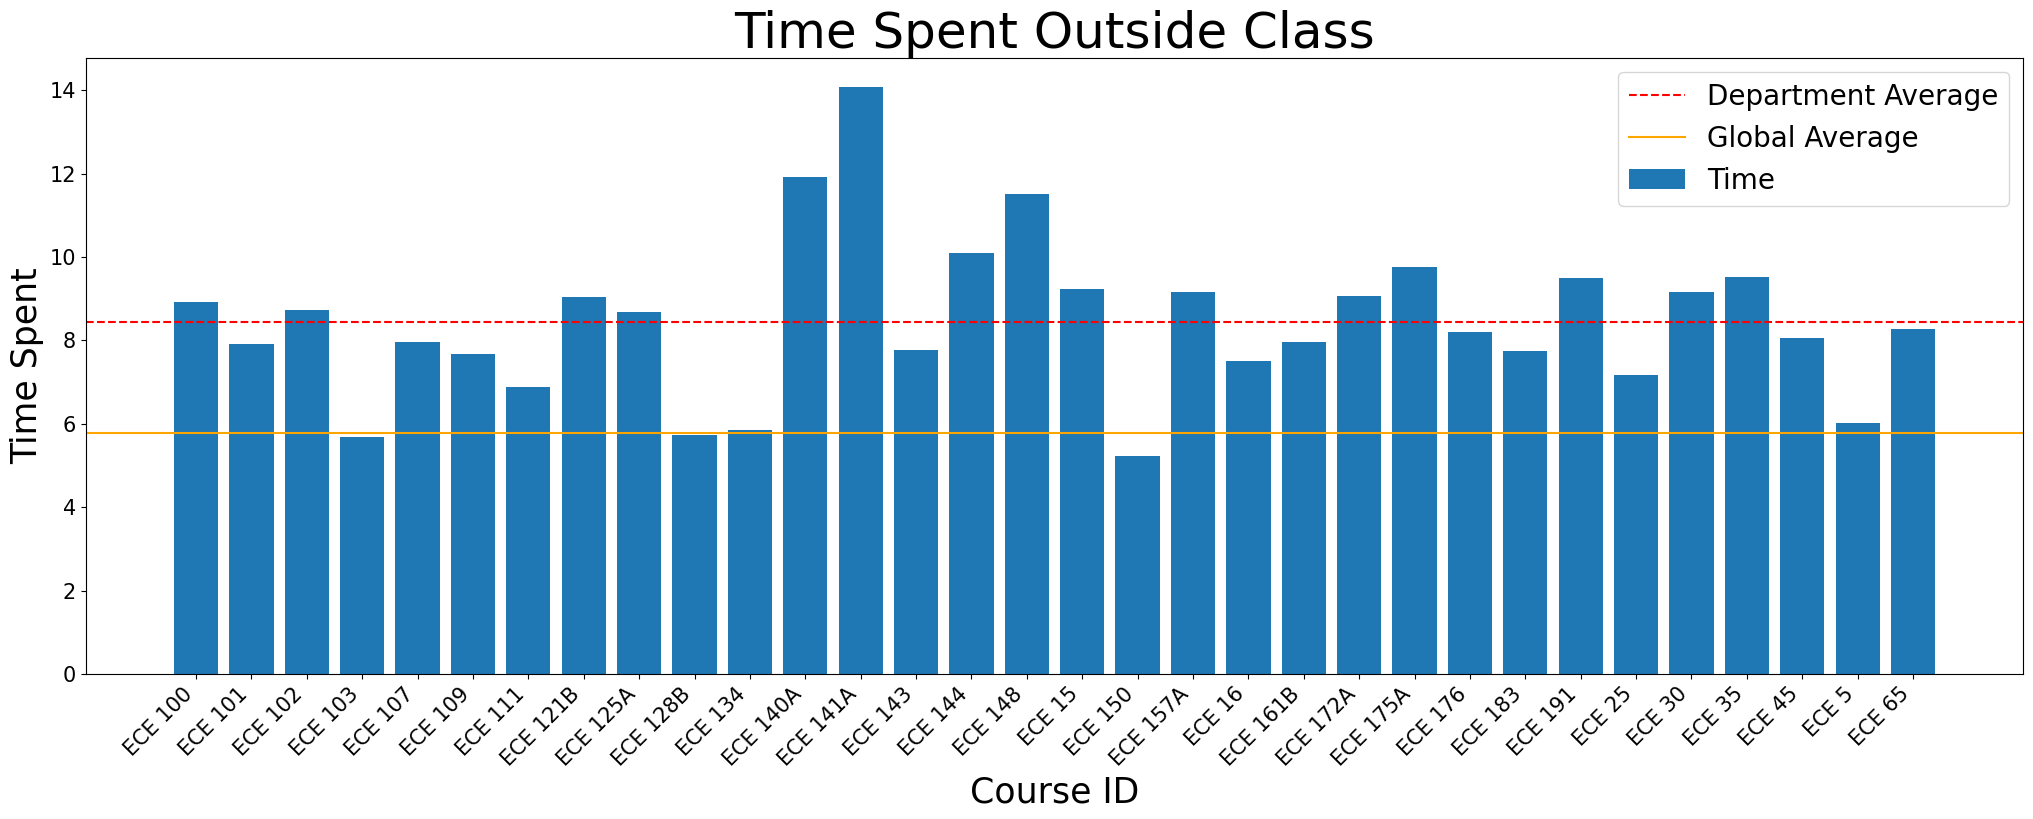

In [23]:

time_draw = time_factor_depart 

plt.figure(figsize=(25, 8))
plt.bar(time_draw['Course_ID'], time_draw['time'], label='Time')

depart_average_time = time_draw['time'].mean()
plt.axhline(y=depart_average_time, color='red', linestyle='--', label='Department Average')

global_average_time = time_draw['global_avg_time'].mean()
plt.axhline(y=global_average_time, color='orange', linestyle='-', label='Global Average')

plt.title('Time Spent Outside Class',fontsize=36)
plt.xlabel('Course ID',fontsize=25)
plt.ylabel('Time Spent',fontsize=25)

plt.xticks(rotation=45, ha='right',fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=20)
plt.grid(False)
plt.show()

In [24]:
# factor 2: difference between actual gpa and expected gpa
global_average_gpa, global_std_gpa = get_global_avg_grade(df2)
grade_dev_factor = get_grade_dev_df(df_quarter,global_average_gpa, global_std_gpa)
grade_dev_factor_depart = grade_dev_factor[grade_dev_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True) # should be changed later for different inputs
# grade_dev_factor_depart = grade_dev_factor.loc[time_factor.index.str.startswith('ECE')].copy()  
print(grade_dev_factor_depart)
dev=pd.DataFrame(grade_dev_factor_depart)

   Course_ID  expected_gpa  actual_gpa   dev  global_avg_grade
0    ECE 100          3.47        3.23 -0.24          3.399484
1    ECE 101          3.21        2.88 -0.33          3.399484
2    ECE 102          3.09        2.98 -0.11          3.399484
3    ECE 103          2.99        2.93 -0.06          3.399484
4    ECE 107          3.10        3.11  0.01          3.399484
5    ECE 109          3.08        2.82 -0.26          3.399484
6    ECE 111          3.65        3.66  0.01          3.399484
7   ECE 121B          3.27        3.18 -0.09          3.399484
8   ECE 125A          3.18        3.06 -0.12          3.399484
9   ECE 128B          3.52        3.54  0.02          3.399484
10   ECE 134          3.47        3.56  0.09          3.399484
11  ECE 140A          3.57        3.36 -0.21          3.399484
12  ECE 141A          3.45        2.88 -0.57          3.399484
13   ECE 143          3.86        3.88  0.02          3.399484
14   ECE 144          3.48        3.62  0.14          3

/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_20001/3468412782.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_average = float(gb.mean())
/var/folders/p2/9qv37hs10bb0jp9zgx1x51v00000gn/T/ipykernel_20001/3468412782.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  global_sd = float(gb.std())


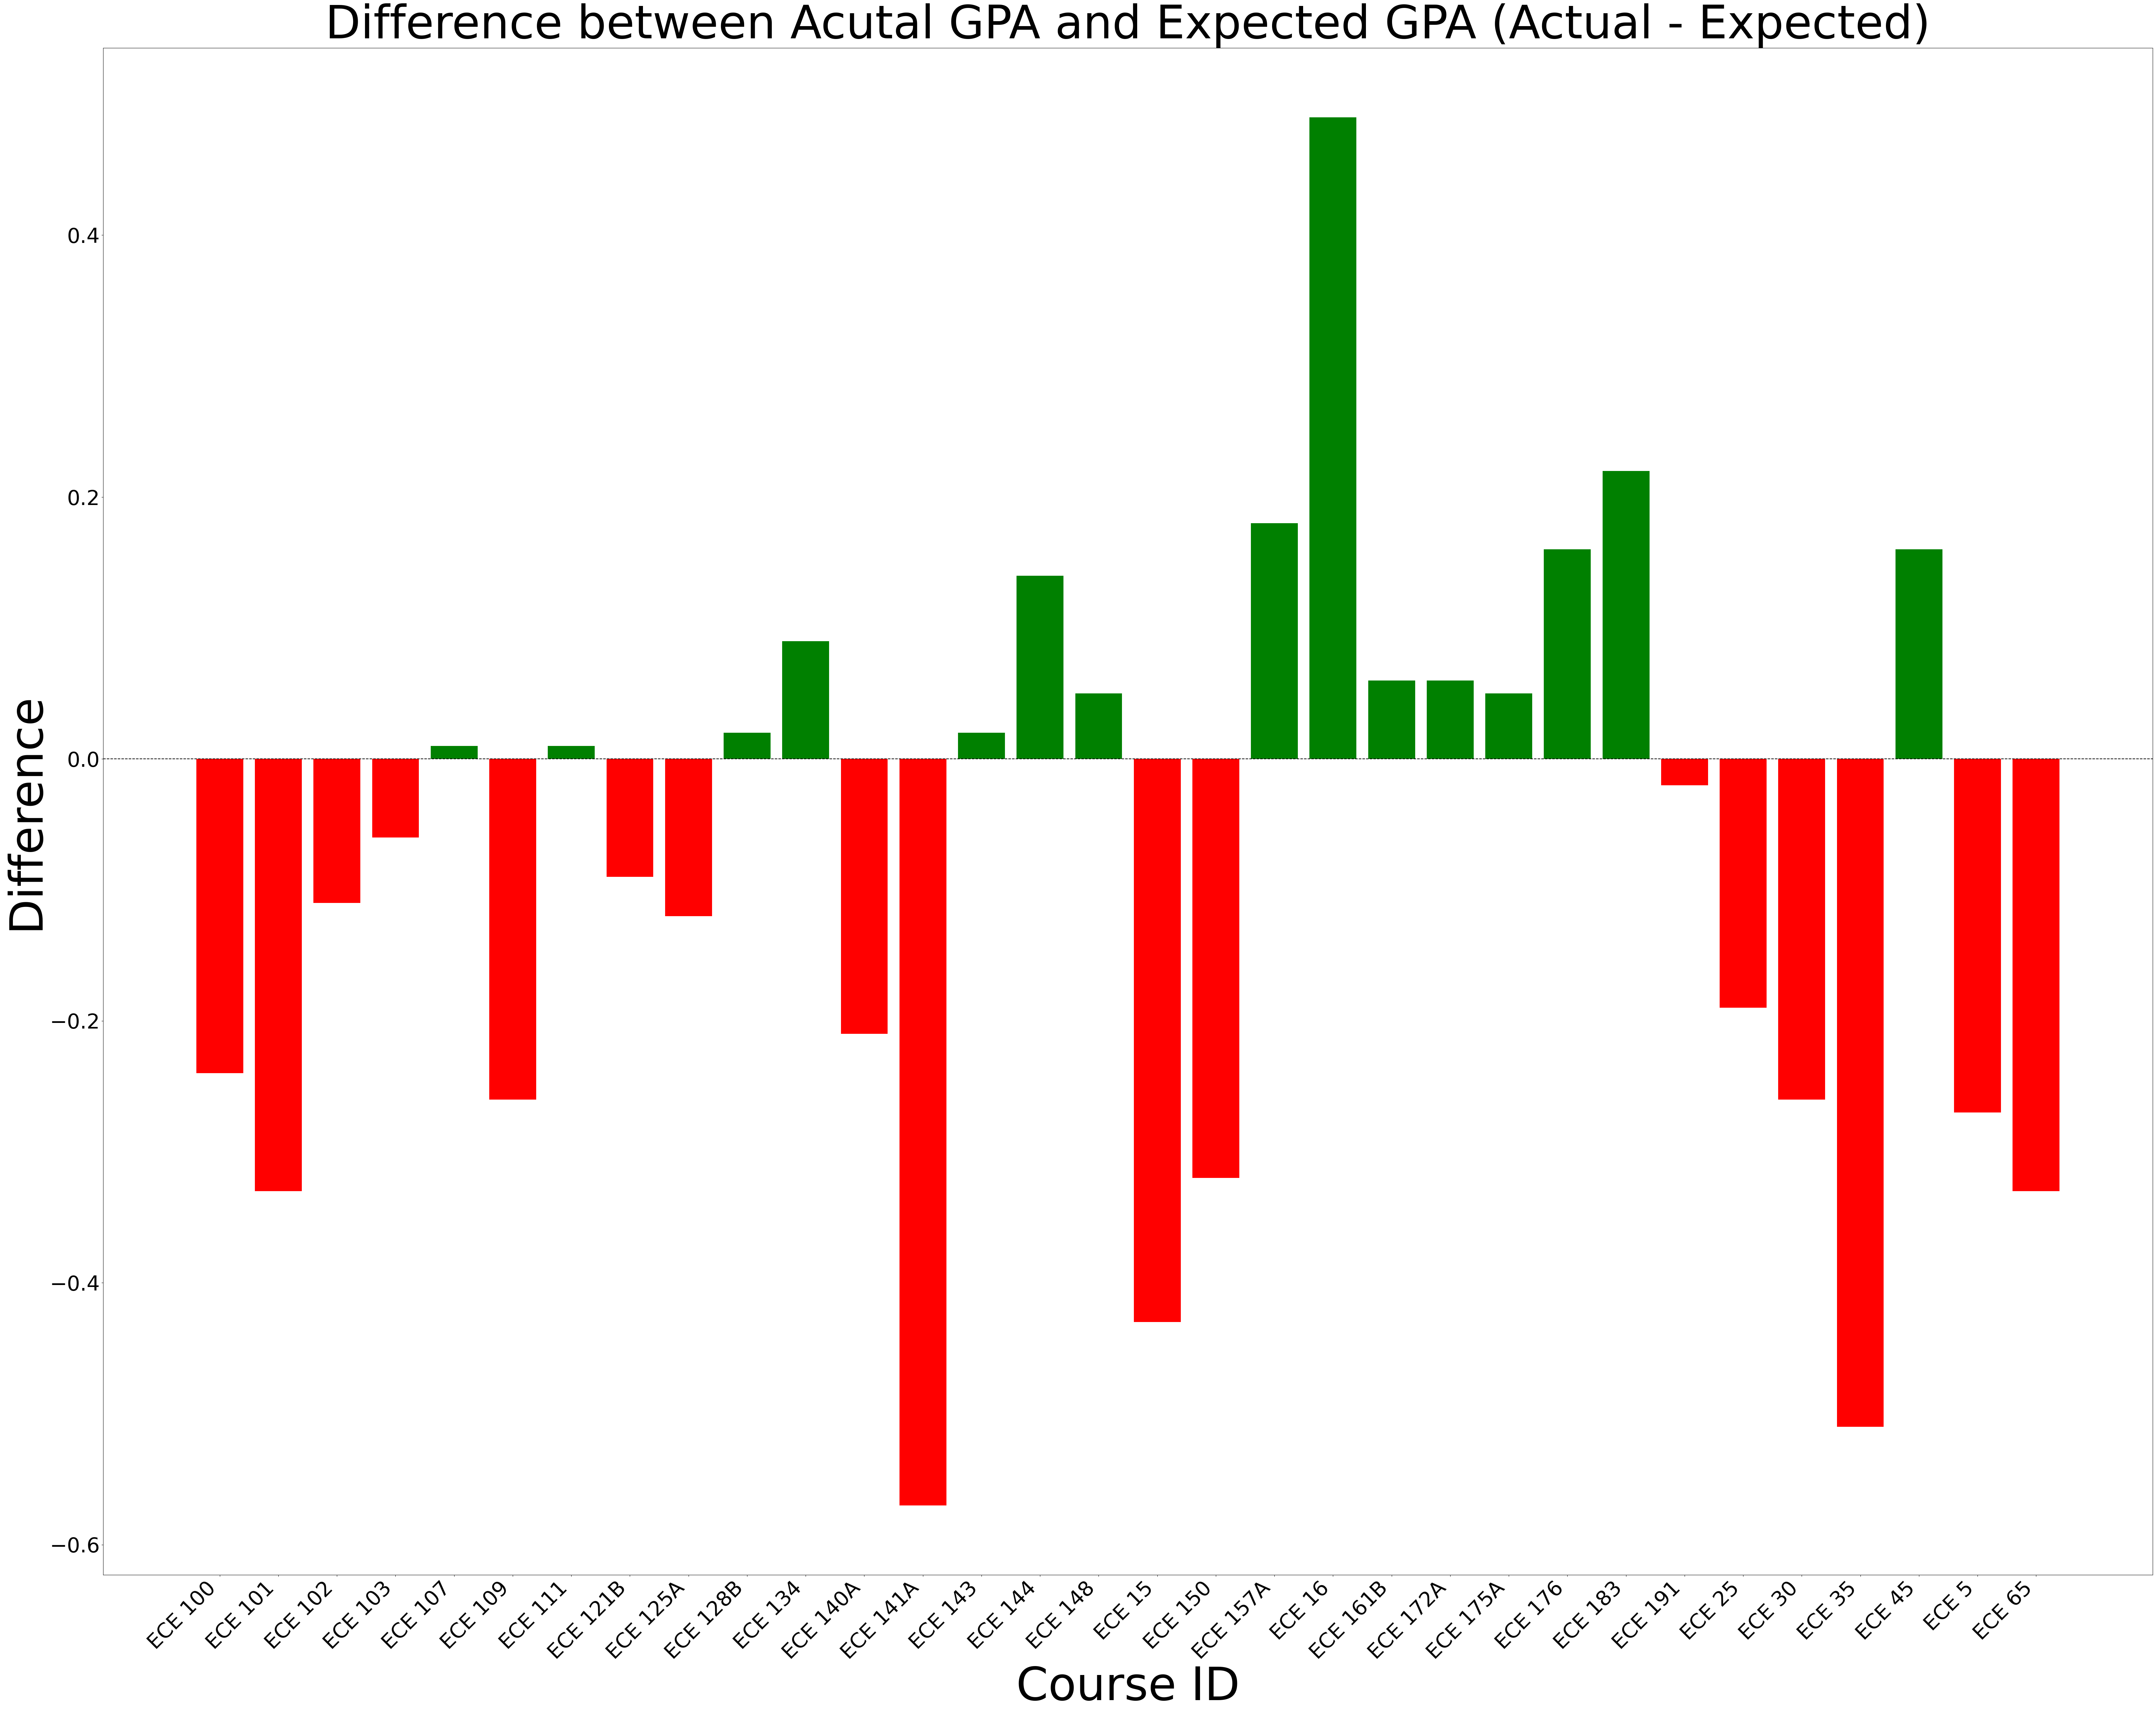

In [25]:
# Sample data
difference=list(dev['dev'])
ID=list(dev['Course_ID'])

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(80,60))
ax.bar(ID, difference, color=['green' if val >= 0 else 'red' for val in difference])

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--')
ax.tick_params(axis='x',labelsize=45)
ax.tick_params(axis='y',labelsize=45)
# Function to update the plot for animation
def update(frame):
    ax.clear()
    ax.barh(ID, difference, color=['skyblue' if val >= 0 else 'orange' for val in difference])
    ax.axvline(x=0, color='black', linestyle='--')
    ax.set_xlim(-15, 15)  # Adjust the x-axis limits as needed
    ax.set_title('Frame: {}'.format(frame))

# Create the animation

animation = FuncAnimation(fig, update, frames=np.arange(0, 100), interval=200)
plt.title('Difference between Acutal GPA and Expected GPA (Actual - Expected)',fontsize=100)
plt.xlabel('Course ID',fontsize=100)
plt.ylabel('Difference',fontsize=100)
plt.xticks(rotation=45, ha='right')
plt.show()


In [26]:
# factor 3: gpa got
grade_factor_depart = grade_dev_factor_depart[['Course_ID','actual_gpa']].copy()
print(grade_factor_depart)



   Course_ID  actual_gpa
0    ECE 100        3.23
1    ECE 101        2.88
2    ECE 102        2.98
3    ECE 103        2.93
4    ECE 107        3.11
5    ECE 109        2.82
6    ECE 111        3.66
7   ECE 121B        3.18
8   ECE 125A        3.06
9   ECE 128B        3.54
10   ECE 134        3.56
11  ECE 140A        3.36
12  ECE 141A        2.88
13   ECE 143        3.88
14   ECE 144        3.62
15   ECE 148        3.84
16    ECE 15        2.76
17   ECE 150        3.46
18  ECE 157A        3.68
19    ECE 16        3.66
20  ECE 161B        3.24
21  ECE 172A        3.36
22  ECE 175A        3.16
23   ECE 176        3.80
24   ECE 183        3.08
25   ECE 191        3.48
26    ECE 25        3.15
27    ECE 30        2.83
28    ECE 35        2.47
29    ECE 45        3.06
30     ECE 5        3.50
31    ECE 65        3.17


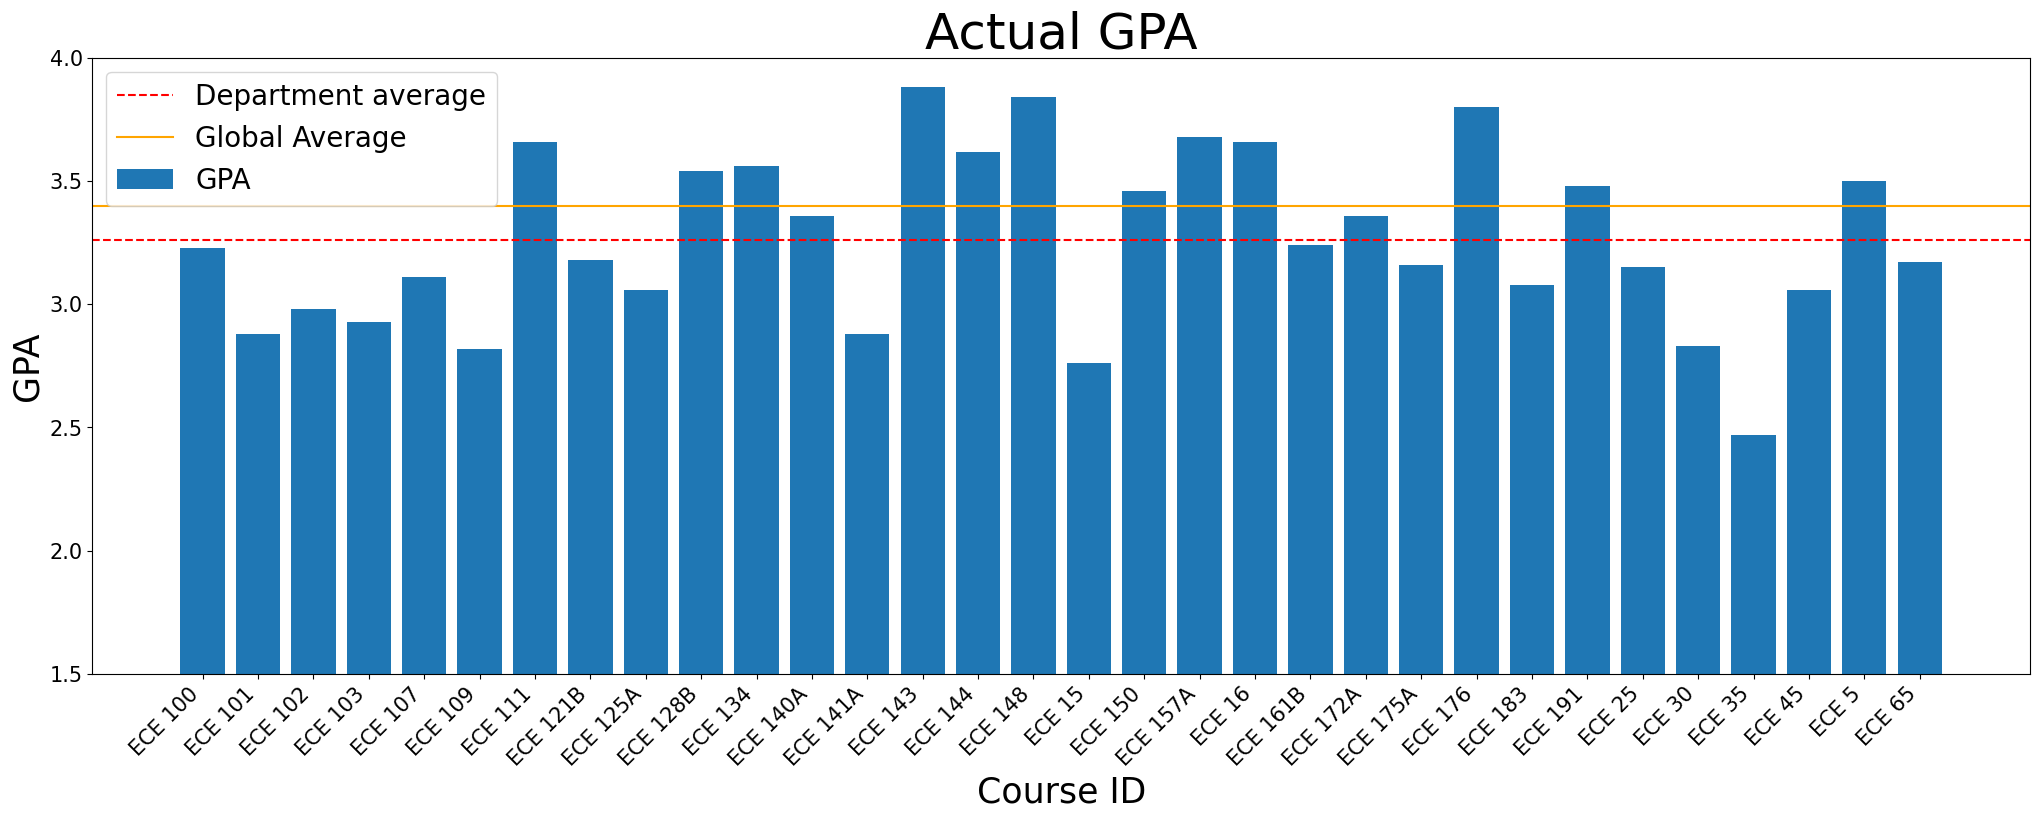

In [27]:
gpa_draw = grade_factor_depart

plt.figure(figsize=(25, 8))
plt.bar(gpa_draw['Course_ID'], gpa_draw['actual_gpa'], label='GPA')

depart_average_gpa = gpa_draw['actual_gpa'].mean()
plt.axhline(y=depart_average_gpa, color='red', linestyle='--', label='Department average')

plt.axhline(y=global_average_gpa, color='orange', linestyle='-', label='Global Average')

plt.title('Actual GPA',fontsize=36)
plt.xlabel('Course ID',fontsize=25)
plt.ylabel('GPA',fontsize=25)

plt.xticks(rotation=45, ha='right',fontsize=15)
plt.yticks(fontsize=15)

plt.ylim(1.5,4)
plt.legend(fontsize=20)
plt.grid(False)
plt.show()

In [28]:
# factor 4: % recommend the class
class_factor = get_class_rmd_df(df_quarter)
class_factor_depart = class_factor[class_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(class_factor_depart)

   Course_ID  rmd_class
0    ECE 100      79.10
1    ECE 101      82.75
2    ECE 102      94.90
3    ECE 103      66.67
4    ECE 107      73.25
5    ECE 109      72.20
6    ECE 111      93.32
7   ECE 121B      90.48
8   ECE 125A      96.10
9   ECE 128B      92.38
10   ECE 134     100.00
11  ECE 140A      81.10
12  ECE 141A      81.35
13   ECE 143      97.40
14   ECE 144      96.43
15   ECE 148      84.60
16    ECE 15      84.28
17   ECE 150      89.85
18  ECE 157A      88.90
19    ECE 16     100.00
20  ECE 161B      96.68
21  ECE 172A      83.10
22  ECE 175A      79.75
23   ECE 176      91.85
24   ECE 183      75.00
25   ECE 191      83.30
26    ECE 25      93.15
27    ECE 30      64.93
28    ECE 35      80.80
29    ECE 45      64.82
30     ECE 5      98.22
31    ECE 65      96.20


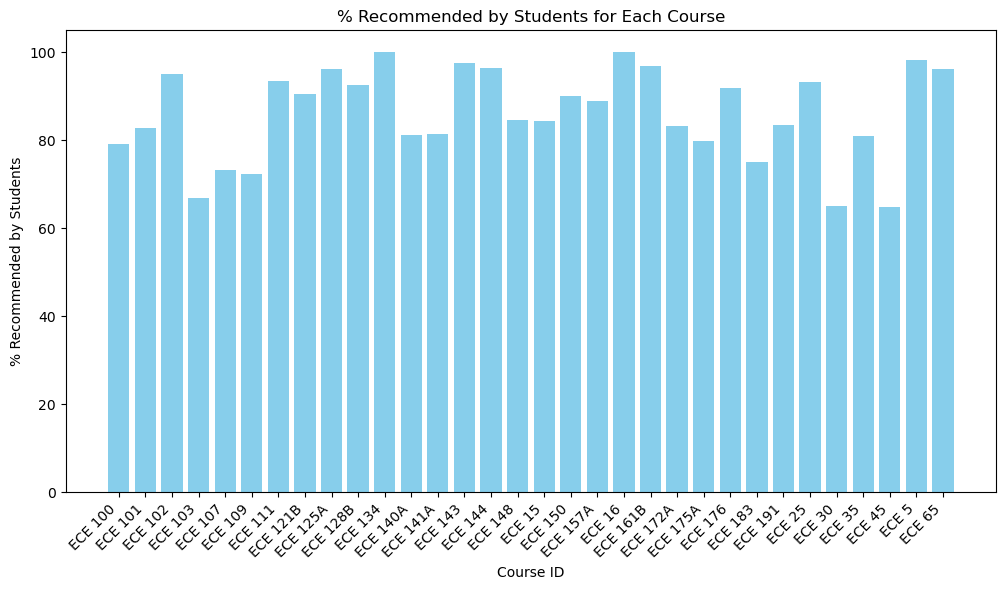

In [29]:
plt.figure(figsize=(12, 6))

plt.bar(class_factor_depart['Course_ID'], class_factor_depart['rmd_class'], color='skyblue')

plt.xlabel('Course ID')
plt.ylabel('% Recommended by Students')
plt.title('% Recommended by Students for Each Course')

plt.xticks(rotation=45, ha='right')

plt.show()

In [30]:
# factor 5: % recommend the instructor
instr_factor = get_instr_rmd_df(df_quarter)
instr_factor_depart = instr_factor[instr_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(instr_factor_depart)

   Course_ID                       instr  rmd_instr
0    ECE 100              Saad, Andrew S      60.50
1    ECE 101        Baghdadchi, Saharnaz      97.63
2    ECE 101              Touri, Behrouz      76.90
3    ECE 102               Le, Hanh-Phuc      96.15
4    ECE 103                  Lo, Yu-Hwa      75.00
5    ECE 103                  Taur, Yuan      44.95
6    ECE 107            Lomakin, Vitaliy      78.50
7    ECE 109            Vardy, Alexander      78.90
8    ECE 109           Zeger, Kenneth A.      83.40
9    ECE 111                 Eldon, John      95.20
10   ECE 111               Karna, Vishal     100.00
11   ECE 111         Koushanfar, Farinaz      83.30
12  ECE 121B         Esmaili, Gholamreza      93.65
13  ECE 125A         Esmaili, Gholamreza      88.90
14  ECE 125A               Le, Hanh-Phuc      93.30
15  ECE 128B  Abi Samra, Nicholas Camill      97.23
16  ECE 128B         Esmaili, Gholamreza      72.20
17   ECE 134                 Ng, Tse Nga     100.00
18  ECE 140A

## Check if a specific class is recommended or not

Type the class you are interested in and we will let you know the best professors and if we recommend it or not. The departments should be selected before

Ex. ECE 143


In [31]:
class_in = input("Type you desired class:")
assert len(class_in) != 0, 'Input should not be none'
class_in_dept, class_in_num = class_in.split()
class_in_dept = class_in_dept.upper()
selected_depts_dict = {}

for dept in depts:
    selected_depts_dict[dept] = all_depts_dict[dept]

assert class_in_dept in selected_depts_dict, 'The input department is not selected before'
assert class_in_num in selected_depts_dict[class_in_dept], 'Course id is not valid for the department'

class_in = class_in_dept + ' ' + class_in_num 
class_in

Type you desired class:ECE 143


'ECE 143'

In [32]:
# Creates dataframe of entries for input class id and sorts by rec_score

df_class = df_quarter[df_quarter['Course_ID'].str.contains(class_in)]
df_class_grouped = df_class.groupby('instr').mean().round(2).reset_index()
df_class_grouped = df_class_grouped.sort_values(by = 'rec_score', ascending = False).reset_index()
df_class_grouped

,index,instr,enroll,evals,rmd_class,rmd_instr,time,expected_gpa,actual_gpa,inv_time,gpa_diff,actual_gpa_percentile,rmd_class_percentile,rmd_instr_percentile,time_percentile,gpa_diff_percentile,rec_score
0,0,"Unpingco, Jose H.",107.5,73.75,97.4,97.88,7.78,3.86,3.88,-7.78,0.01,96.99,81.13,75.46,59.95,70.49,76.43


In [33]:
# Presents data to user
result_2 = df_class_grouped[['instr']]

print('Based on your preferences, these are the professors ranked for ' + str(class_in)+ ': \n')
print(result_2)

Based on your preferences, these are the professors ranked for ECE 143: 

               instr
0  Unpingco, Jose H.


In [34]:
rmd_score = df_group[df_group['Course_ID'].str.contains(class_in)]['rec_score']
num_score = rmd_score.values[0]

if num_score > 75:
    print('We strongly recommend taking this class.' + '\n' +'Based on your preferences we give it a ranking of ' + str(num_score) + "/100")
elif num_score > 50:
    print('We recommend taking this class.' + '\n' +'Based on your preferences we give it a ranking of ' + str(num_score) + "/100")
elif num_score > 25:
    print('We do not recommend taking this class.' + '\n' +'Based on your preferences we give it a ranking of ' + str(num_score) + "/100")
else:
    print('We strongly do not recommend taking this class.' + '\n' +'Based on your preferences we give it a ranking of ' + str(num_score) + "/100")


We strongly recommend taking this class.
Based on your preferences we give it a ranking of 76.43/100
